In [25]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from CodeBase import *

Issue: the eigenvalues of the random louvillian
    recreate the lemon shape of figure 1(c) but
    they seem to be almost exactly smaller by a
    factor of 10, I cant find the cause of this.

DSFF = 0, z_k = 10
GinUE=0,Poisson=1,Random_louvillian=22
Create symmetries in the random Louvillian?0
Calculating the Dissipative Spectral Form Factor for the chosen model.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 21.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 34.3min finished


save graph?1
Name of DSFF graph?bigger one


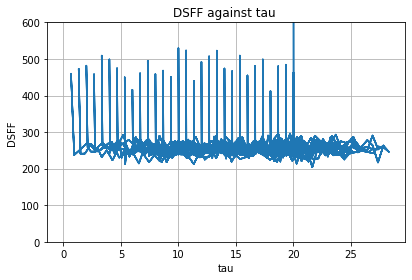

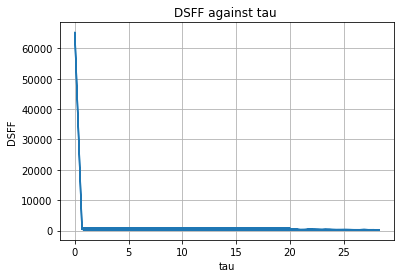

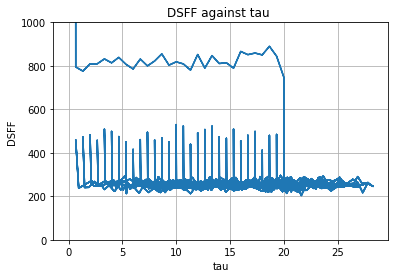

(256, 256)


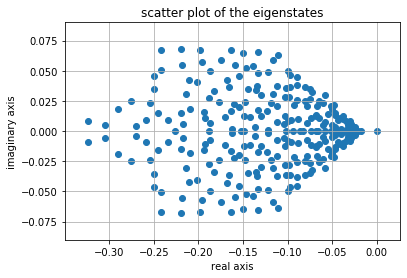

In [5]:
class lindbladian_Louville_operator():
    def __init__(self,N,h,J,J_prime,delta,delta_prime,b,t,tau,nv,NH,M_choice,
                gamma0,gamma_L_plus,gamma_L_min,gamma_R_plus,gamma_R_min,
                N_L,g,r,t_min,t_max,s_min,s_max,res,av_num,n):

        for local in locals().copy(): 
            ## equivalent of writing self.gamma = gamma,self.b = b etc.
            ## without having to rewrite it.
            exec('self.' + local +  ' = locals()[local]')
        
        """Boolean which decides whether to calculate the complex ratio signatures of the spectrum,
        or to calculate the dissipative spectral form factor."""
        self.simulation_choice = int(input('DSFF = 0, z_k = 1'))
        
        if self.simulation_choice == 0:
            """GinUE: Ginibre unitary ensemble
               Poisson: a Poisson spectrum
               Random_Louvillian: defined in arXiv:1905.02155."""
            self.stat_bool = int(input('GinUE=0,Poisson=1,Random_louvillian=2'))
            
            if self.stat_bool == 2:
                self.sym_bool = int(input('Create symmetries in the random Louvillian?'))
            print('Calculating the Dissipative Spectral Form Factor for the chosen model.')    
            self.run_DSFF_code()
        
        else:    
            self.model_choice = int(input('Which Model? Deph = 0, Heisenberg XXX = 1, non H XXX = 2,Random Louvillian=3,Next-to-nearest-neighbour-Heisenberg XXZ Hamiltonian=4, no specific model=5'))
            
            ##setting up random Louvillian
            if self.model_choice==3:
                self.sym_bool = int(input('Create symmetries in the random Louvillian?'))
                self.initialise_Random_Louvillian()
            else:
                ###initialising variables so they don't have to called in 
                ###each function
                self.proj_bool = int(input('Project onto spin subspace?'))
                self.initialise_variables()    
            
            print("Variables initialised,calculating the Louvillian.")

            ##calls function to create the Liouvillian
            self.Louv = self.L(0)

            self.evals = (self.Louv).eigenenergies()
            print("Calculating P, the time evolution matrix.")

            ##calls function to create P and solve for the eigenenergies.
            #self.P,self.evals = self.P()

            ##calls function to create z_k along with the degeneracy factor of each ratio
            self.deg_factor = np.unique(self.evals,return_counts=True)[-1]
            deg_bool = int(input('Remove degeneracy?'))
            if deg_bool:

                self.E_array,self.deg_factor = np.unique(self.evals,return_counts=True)
            else:   

                ##defining E_array for z_k_spec and for the parallelization
                self.E_array = self.evals

            """Currently using the non-parallelised z_k function."""
            #self.z_k = parallelise_job(self.z_k_spec,self.E_array,verbose = False)
            self.z_k = self.z_k(self.E_array)


            ##choice of whether to save data
            self.save_boolean = bool(int(input('Save Data?')))
            self.add_to_average = int(input('Add to average?'))

            ##defines path for my computer
            self.path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/'  

            ##retrieves the single number signatures of the data.
            self.mean_r, self.mean_cos, self.mean_theta = self.single_number_signatures(self.z_k)


            ##list of all parameters needed
            data_list = ['mean_r='+str(self.mean_r),
                         'mean_cos='+str(self.mean_cos),
                         'mean_theta='+str(self.mean_theta),
                         'N='+str(self.N),'h='+str(self.h),
                         'J='+str(self.J),'J_prime='+str(self.J_prime),
                         'delta='+str(self.delta),
                         'delta_prime='+str(self.delta),'b='+str(self.b),
                         't='+str(self.t),'tau='+str(self.tau),
                         'nv='+str(self.nv),'gamma0='+str(self.gamma0),
                         'gamma_L_plus='+str(self.gamma_L_plus),
                         'gamma_L_min='+str(self.gamma_L_min),
                         'gamma_R_plus='+str(self.gamma_R_plus),
                         'gamma_R_min='+str(self.gamma_R_min)]
            ##as array
            data_array = np.asarray((self.mean_r,self.mean_cos,
                         self.mean_theta,self.N,self.h,
                         self.J,self.J_prime,self.delta,self.delta_prime,
                         self.b,self.t,self.tau,
                         self.nv,self.gamma0,self.gamma_L_plus,
                         self.gamma_L_min,self.gamma_R_plus,
                         self.gamma_R_min))

            if self.proj_bool:
                data_list = np.append('M = '+str(self.M_choice),data_list)
                data_array = np.append(self.M_choice,data_array)

            if self.save_boolean:
                ##sorting names
                list_name = 'list, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
                array_name = 'array, N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())


                ##sorting paths 
                self.SNS_path = self.path +'Single Number Signatures/'
                self.z_k_path =self.path + 'z_k raw data/'


                ##Sorting where to save the data
                
                ##Deph model
                if self.model_choice==0:
                    self.z_k_path_final = self.z_k_path+'Deph/'
                    self.SNS_path = self.SNS_path+'Deph/'

                    ##needed for add_to_average function
                    average_path_add_on = ', Deph average.npy'

                ##Heisenberg model
                if self.model_choice==1:
                    self.z_k_path_final = self.z_k_path+'Heisenberg XXX/'
                    self.SNS_path = self.SNS_path+'Heisenberg XXX/'
                    average_path_add_on = ', Heisenberg XXX average.npy'

                ##non-Heisenberg XXX model
                if self.model_choice==2:
                    self.z_k_path_final = self.z_k_path+'non H XXX/'
                    self.SNS_path = self.SNS_path+'non H XXX/'
                    average_path_add_on = ', non H XXX average.npy'


                if not os.path.isdir(self.z_k_path):
                    os.mkdir(self.z_k_path)
                if not os.path.isdir(self.SNS_path):
                    os.mkdir(self.SNS_path)

                self.list_path = self.SNS_path+list_name
                self.array_path = self.SNS_path+array_name


                if self.add_to_average:
                    ##calls function to average data with all previous relevant simulations 
                    self.averaging_data(self.z_k_path,data_list=data_list,average_path_add_on=average_path_add_on)

                ##pathways for graphs

                self.label_add_on = ', N = '+str(self.N) + ', h = '+str(self.h) +', ' +str(datetime.datetime.today().date())
                if self.proj_bool:
                    self.label_add_on = 'M= '+str(self.M_choice) +self.label_add_on
                self.graph_path_r = self.z_k_path_final+'r barchart ,'+self.label_add_on
                self.graph_path_theta = self.z_k_path_final+'theta barchart ,'+self.label_add_on
                self.heatmap_path = self.z_k_path_final+'heatmap,'+self.label_add_on
                self.z_k_path_final = self.z_k_path_final+'z_k,'+self.label_add_on


                np.save(self.z_k_path_final+'.npy',self.z_k)
                np.save(self.list_path+'.npy',data_list)
                np.save(self.array_path+'.npy',data_array)

            ##plots data
            self.heatmap(self.z_k,self.deg_factor)
            print('mean r value = '+ str(self.mean_r))
            print('mean cos(theta) = '+str(self.mean_cos))
            print('mean theta = '+str(self.mean_theta))
        
    def averaging_data(self,path,data_list,average_path_add_on):
        """
        Adds the newly simulated data to the data set of all previous simulations with appropriate
        weighting for averaging.
        """
        
        
        ##if the average has not been done before, the file must first be created
        trig = int(input('First time inputing data for the average of this model?'))
        if trig:
                ##creates a list of size 3, with the inputs being
                ##the data, the number of datasets added and the parameters (data_list) respectively.
                z_k_av = [self.z_k,1,data_list]
                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on, z_k_av)                 
        else:
            ##loading the average of previous simulations
            z_k_av = np.load(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on,
                            allow_pickle=True)
            ##checking to see if they both have the same parameters
            if data_list != z_k_av[-1]:
                raise AttributeError('Trying to add two sets of data with different parameters')
            else:
                ##adding to the average data mathematically.
                z_k_av_updated = []
                z_k_av_updated.append((z_k_av[1]*z_k_av[0] + self.z_k)/(z_k_av[1]+1))
                z_k_av_updated.append(z_k_av[1]+1)
                z_k_av_updated.append(data_list)

                np.save(path+'N=' + str(self.N) +' , b=' +str(self.b)+average_path_add_on, z_k_av_updated)
    
    
    def initialise_Random_Louvillian(self,):
        """Sets up the variables so the function L will give a 
        Beta =2 Random Louvillian as defined by the paper."""
        n=self.N_L**2
        self.proj_bool = 0
        
        ##supposing we have an array of numbers which gives the 
        ##dimensions of the blocks, the following with create this block 
        ##diagonal matrix.
        array = np.asarray([n/2,n/2])
        if self.sym_bool:
            self.H1 = np.zeros((np.product(array),np.product(array)))
            for i in range(np.size(array)):
                Gaus = Qobj(np.random.normal(scale=1/np.sqrt(2*n),size=(array[i],array[i])) + 1j*np.random.normal(scale=1/np.sqrt(2*n),size=(array[i],array[i])))
                
                ##OR
                ##not sure what the variance should be for the sub matrices (blocks), should it be 1/array[i] or 1/n
                
                Gaus = Qobj(np.random.normal(scale=1/np.sqrt(2*array[i]),size=(array[i],array[i])) + 1j*np.random.normal(scale=1/np.sqrt(2*array[i]),size=(array[i],array[i])))
                
                
                
                sub_H1 = ((Gaus + Gaus.dag())/2)
                start_idx = np.sum(array[:i])-array[i]
                end_idx = np.sum(array[:i])
                self.H1[start_idx:end_idx,start_idx:end_idx]=sub_H1
        if not self.sym_bool:
            Gaus = Qobj(np.random.normal(scale=1/np.sqrt(2*n),size=(n,n)) + 1j*np.random.normal(scale=1/np.sqrt(2*n),size=(n,n)))
            self.H1 = ((Gaus + Gaus.dag())/np.sqrt(2))        
        
        self.W_list = []
        
        for i in range(self.r):
                W = self.g*Qobj(np.random.normal(scale=1/np.sqrt(2*n),size=(n,n)) + 1j*np.random.normal(scale=1/np.sqrt(2*n),size=(n,n)))
                self.W_list.append(W)
        self.identity = qeye(n)
        
    def initialise_variables(self,):
        """
        Defines all generic variables that are needed for the simulation.
        """

        si = qeye(2) #identity for a spin-1/2 particle
        sz = sigmaz() ## z pauli matrix
        sx = sigmax() ## y pauli matrix
        sy = sigmay() ## y pauli matrix
        sigp = sigmap() ##plus ladder operator for spin 1/2
        sigm = sigmam() ##minus ladder operator for spin 1/2
        self.sz_list = []
        sx_list = []
        sy_list = []
        sigp_list = []
        sigm_list = []
        h_arr = np.random.uniform(-self.h,self.h,self.N) ##random uniform distribution from -h to h

        for n in range(self.N):
            op_list = []
            for m in range(self.N):
                op_list.append(si) ##creates a list of identity operators for each particle
            self.identity = tensor(op_list) ##creates an identity over the 2^N x 2^N space
            
            
            op_list[n] = sz
            self.sz_list.append(tensor(op_list))

            op_list[n] = sx
            sx_list.append(tensor(op_list))
            
            op_list[n] = sy
            sy_list.append(tensor(op_list))
            
            if n==0:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))
            if n==self.N-1:
                op_list[n] = sigp
                sigp_list.append(tensor(op_list))

                op_list[n] = sigm
                sigm_list.append(tensor(op_list))

        
        if self.proj_bool:
            self.S_z_tot = sum(self.sz_list)
            self.S_z_super = tensor(self.S_z_tot,self.identity) - tensor(self.identity,self.S_z_tot.trans())

            ##M_indices gives the columns/rows of the matrix representation of the basis
            ##that have M=M_choice
            """Note that the eigenvalues of S_z_super are given by 2(N-M) rather than (N-M). This is because when 
            a spin is flipped the change in eigenvalue is 2 (in this representation |s_l|=1, not 1/2)"""
            self.M_indices = np.where(self.S_z_super.diag()==(2*self.N-2*self.M_choice))[0]

            ##list of dummy indices for parallelisation
            self.y = range(len(self.M_indices))

            ##inputs for parallelisation of projection
            """This creates an array of shape (N_m*N_m,2) where N_m is the dimension of the subspace. The first entry is 
            the M index, and the second is a dummy index for labelling (ordering after parallelisation)."""
            #self.inputs = [(self.M_indices[i],self.M_indices[j],self.y[i],self.y[j]) for i in range(len(self.y)) for j in range(len(self.y))]
            self.inputs = [(self.M_indices[i],self.y[i]) for i in range(len(self.y))]

            ##defines the dimension of the M spin subspace
            self.dim_M = np.size(self.M_indices)
            if self.dim_M != ss.comb(2*self.N,self.M_choice):
                raise AttributeError('Size of matrix is not 2N choose M') 

        ## construct the hamiltonian 
        H_S = 0
        self.Hk = 0
        W_list = [] ##list of jump operators

        # energy splitting terms
        for n in range(self.N):
            
            ##random field term
            H_S += h_arr[n] * self.sz_list[n]
            ##bulk dephasing
            W_list.append(np.sqrt(self.gamma0) * self.sz_list[n])
            ##kicking term
            self.Hk += self.b * sx_list[n]
            

        # interaction terms
        for n in range(self.N-1): 
            H_S += self.J * self.delta * self.sz_list[n] * self.sz_list[n+1]
            H_S += self.J * sx_list[n] * sx_list[n+1]
            H_S += self.J * sy_list[n] * sy_list[n+1]
        
        
        if self.model_choice == 4:
            for n in range(self.N-2): 
                H_S += self.J_prime * self.delta_prime * self.sz_list[n] * self.sz_list[n+2]
                H_S += self.J_prime * sx_list[n] * sx_list[n+2]
                H_S += self.J_prime * sy_list[n] * sy_list[n+2]
                
        self.H1 =H_S

        ##amplitude damping
        W_list.append(np.sqrt(self.gamma_L_plus)*sigp_list[0]) ##W_{N+1}
        W_list.append(np.sqrt(self.gamma_L_min)*sigm_list[0]) ##W_{N+2}
        W_list.append(np.sqrt(self.gamma_R_plus)*sigp_list[1]) ##W_{N+3}
        W_list.append(np.sqrt(self.gamma_R_min)*sigm_list[1]) ##W_{N+4}
        
        self.W_list = W_list
        self.sigp_list = sigp_list
        self.sigm_list = sigm_list

    
    def spin_proj(self,matrix,M_choice):
        """
        Takes a matrix in the whole hilbert space and projects to the M_choice subspace.
        This function is inefficient as the whole matrix has to be calculated as an input, 
        this function isn't being currently used.
        """

        #This gives the rows/columns (eigenstates) that have don't have M=M_choice
        M_choice_indices = np.where(self.S_z_super.diag()!=M_choice)[0]
        for i in range(np.size(M_choice_indices)):
            ##np.delete is used to remove the rows and columns that correspond to 
            ##eigenstates that don't have the desired spin state.
            ## the -i factor accounts for the fact that each iteration a row and column
            ##is removed, decreasing the index by 1 each time.
            matrix = np.delete(arr=matrix,obj=M_choice_indices[i]-i,axis=0)
            
            #deletes the ith column
            matrix = np.delete(arr=matrix,obj=M_choice_indices[i]-i,axis=1)
        return matrix

    
    def L(self,i):
        """
        creates L from the definition of its matrix representation, 
        equation 4.1 of the notes currently. 
        """
        
        W_term = 0 
        ###calculates sum_{\mu}(W_{\mu}^{\dag}*W_{\mu})
        for i in range(len(self.W_list)):
            W_term += (self.W_list[i].dag())*self.W_list[i]
               
        H_left = self.H1 - (1j/2)*W_term
        H_right = self.H1 + (1j/2)*W_term

        H_cross_term = 0
        ##calculates  sum_{\mu}(W_{\mu}\otimes W_{\mu}^{\dag})
        for i in range(len(self.W_list)):
            if self.proj_bool:
                self.A = self.W_list[i]
                self.dim_A = self.A.shape[0]
                self.B = self.W_list[i].conj()
                #H_cross_term += self.projection(self.M_indices)

                outputs = dict(parallelise_job(self.para_projection,self.inputs))
                
                output = np.column_stack([outputs[j] for j in self.y])
                H_cross_term += output
            else:
                H_cross_term += tensor(self.W_list[i],self.W_list[i].conj())
                
        if self.proj_bool:
            self.A = H_left
            self.B = self.identity
            outputs = dict(parallelise_job(self.para_projection,self.inputs))
            L = -1j*np.column_stack([outputs[i] for i in self.y])
            
            self.A = self.identity
            self.B = H_right.trans()
            outputs = dict(parallelise_job(self.para_projection,self.inputs))
            L += 1j*np.column_stack([outputs[j] for j in self.y])
        else:
            L = -1j*tensor(H_left,self.identity)
            L += 1j*tensor(self.identity,H_right.trans())
            
        
        L += H_cross_term
        
        return Qobj(L)
    
    def P(self,):
        
        if self.t>(self.tau/2):
            ##defining the commutator kicking superoperator
            if self.proj_bool:
                self.A = self.Hk
                self.dim_A = self.A.shape[0]
                self.B = self.identity
                HK_commute_SO = dict(parallelise_job(self.para_projection,self.inputs))
                HK_commute_SO = -1j*np.column_stack([outputs[j] for j in self.y])

                self.A = self.identity
                self.B = self.Hk.trans()
                output = dict(parallelise_job(self.para_projection,self.inputs))
                output = 1j*np.column_stack([outputs[j] for j in self.y])
                HK_commute_SO += output
            else:
                HK_commute_SO = -1j*tensor(self.Hk,self.identity)
                HK_commute_SO += 1j*tensor(self.identity,self.Hk.trans())
                HK_commute_SO = Qobj(spin_proj(matrix = HK_commute_SO, M_choice=self.M_choice))
            
        
        ###exponentiates the matrices and calculates P
            expH = Qobj(HK_commute_SO).expm()
            exp1 = (self.Louv*self.tau/2).expm()
            exp2 = (self.Louv*(self.t-self.tau/2)).expm()
            P = exp2*(expH*exp1)
        if self.t<=self.tau/2:
            P = (self.Louv*self.t).expm()
        
        evals = P.eigenenergies()
       
        

        return P,evals
    
    def projection(self,A,B,M_indices):
        """
        Calculates the columns of the whole matrix representation that give the 
        desired subspace. This is the unparallelised version, which 
        isn't currently being used.
         The loop takes the the column/row indices and calculates what element they correspond to in
         the Kronecker product of A cross B. For explanation of the R, K terms see the latex notes.
        """

        ##M_indices is the list of rows/columns of
        ##the whole space matrix representation that
        ##have the quantum number M

        ##A and B are matrices that have dimensions of 2^N by 2^N

        dim_M = np.size(M_indices)
        dim_A = A.shape[0]
        ##out is a matrix of zeros that has dimensions of the subspace.
        out = np.zeros((dim_M,dim_M),dtype=np.complex64)
        n=-1
        for i in tqdm_notebook(M_indices,leave=False):
            m = 0
            n += 1
            for j in M_indices:
                R_i = np.floor(i/dim_A)
                R_j = np.floor(j/dim_A)
                K_i = i -dim_A*R_i
                K_j = j -dim_A*R_j
                #print(R_j)
                #print(M_indices[-1])
                #print(np.max(np.array((R_i,R_j,K_i,K_j))))
                A_cross_B_ij = A[R_i,R_j]*B[K_i,K_j]
                out[n,m] = A_cross_B_ij
                m +=1
        return Qobj(out)
    
    def para_projection(self,M_index_y):
        """
        Parallelised version of the projection function.
        """
        ##y is a list of dummy indices needed to recover the 
        ##order after parallelisation
        M_index,y = M_index_y
        
        ##M_index is one of the rows/columns of
        ##the whole space matrix representation that
        ##have the quantum number M

        ##A and B are matrices that have dimensions of 2^N by 2^N

        ##out is a matrix of zeros that has dimensions of the subspace.
        out = np.zeros(self.dim_M,dtype=np.complex64)
        m=0
        R_i = np.floor(M_index/self.dim_A)
        K_i = M_index -self.dim_A*R_i
        for j in self.M_indices:
            R_j = np.floor(j/self.dim_A)
            K_j = j -self.dim_A*R_j
            A_cross_B_ij = self.A[R_i,R_j]*self.B[K_i,K_j]
            out[m] = A_cross_B_ij
            m +=1
        return y, Qobj(out)
    
    
    def GinUE_or_Pois(self,i):
        """n by n is the size of the GinUE matrix"""
        """array of which the DSFF is calculated."""
        #The elements of a GinUE matrix are (2D) gaussian distributed
        #with 1/N variance
        if self.stat_bool==0:
            GinUE = Qobj(np.random.normal(scale=1/np.sqrt(self.n),size=(self.n,self.n)) +1j*np.random.normal(scale=1/np.sqrt(self.n),size=(self.n,self.n)))
            z = GinUE.eigenenergies()
            #z = z/np.sqrt(self.n)
        #Poisson
        if self.stat_bool==1:
            z= np.random.normal(scale=1,size=(self.n)) +1j*np.random.normal(scale=1,size=(self.n))
            
        """calls DSFF function to retrieve variables, see DSFF code for definitions."""
        return self.DSFF(z)
    
    def run_Louv(self,i):
        self.initialise_Random_Louvillian()
        L = self.L(0)
        z = 10*(L).eigenenergies()
        return self.DSFF(z)
    
    def run_DSFF_code(self,):
    
        """t_min,t_max,s_min,s_max and res
        set up grid for t and s variables.
        av_num is the number of random matrices sampled."""
        
        
        self.t= np.linspace(self.t_min,self.t_max,self.res)
        self.s = np.linspace(self.s_min,self.s_max,self.res)
        
        """does the same as for x_n and y_m etc but for the time variables."""
        t_n, s_n = self.t.reshape(-1,1), self.s.reshape(-1,1)
        t_n, s_n = t_n.repeat(self.res,1),s_n.repeat(self.res,1)
        t_m, s_m = t_n.transpose(), s_n.transpose()

        """the elements of tau_matrix give all the points 
        in the t,s (complex) grid."""
        self.tau_matrix = 1j*s_m +t_n 

        out = 0
        if self.stat_bool != 2:
            o = parallelise_job(self.GinUE_or_Pois,range(self.av_num),verbose = True,n_jobs = -1)
        if self.stat_bool == 2:
            o = parallelise_job(self.run_Louv,range(self.av_num),verbose = True,n_jobs = -1)
            
        for _ in o:
            out += _

        DSFF_ = out/(self.av_num+1)
        self.tau_mag = np.abs(self.tau_matrix).flatten(order='C')
        self.DSFF_ = np.abs(DSFF_).flatten(order='C')


        path = 'C://Users/david/OneDrive/Documents/UNI/UCL project/data/'
        save = int(input("save graph?"))
        
        plt.plot(self.tau_mag,self.DSFF_)
        plt.grid()
        plt.xlabel('tau')
        plt.ylabel('DSFF')
        plt.title('DSFF against tau ')
        if save:
            path_add_on = input('Name of DSFF graph?')
            path = path+ str(path_add_on)
            plt.gcf().tight_layout()        
            plt.savefig(path+'.png',dpi=250)
        plt.ylim(0,600)
        plt.show()
        
        plt.plot(self.tau_mag,self.DSFF_)
        plt.grid()
        plt.xlabel('tau')
        plt.ylabel('DSFF')
        plt.title('DSFF against tau ')
        #plt.ylim(0,600)
        plt.show()
        
        plt.plot(self.tau_mag,self.DSFF_)
        plt.grid()
        plt.xlabel('tau')
        plt.ylabel('DSFF')
        plt.title('DSFF against tau ')
        plt.ylim(0,1000)
        plt.show()
        
        
        ###creating a matrix of the given model to plot the eigenenergies.
        if self.stat_bool==0:
            GinUE = Qobj(np.random.normal(scale=1/np.sqrt(2*self.n),size=(self.n,self.n)) +1j*np.random.normal(scale=1/np.sqrt(2*self.n),size=(self.n,self.n)))
            z = GinUE.eigenenergies()
            
        if self.stat_bool==1:
            z= np.random.normal(scale=1/np.sqrt(2),size=(self.n)) + 1j*np.random.normal(scale=1/np.sqrt(2),size=(self.n))
        if self.stat_bool==2:
            self.initialise_Random_Louvillian()
            L = self.L(0)
            print(np.shape(L))
            z = (L).eigenenergies()
            self.factor = 2*self.N_L*np.sqrt(2*self.r)*self.g*self.g#np.sqrt(2*self.r)*self.g*self.g*2*self.N_L
            z = z/self.factor
        
        
        x = (z).real
        y = (z).imag
        
        plt.scatter(x,y)
        plt.grid()
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('scatter plot of the eigenenergies')
        plt.show()



        
    '''''''''''''''''Level Statistics functions'''''''''''''''''
    def z_k(self,E_array):
        z_k = [] ##setting up ratio array
        
        
        for i in tqdm_notebook(range(np.size(E_array)),leave=False):
                
            ##creating an array of the indices of the ratios ascending in magnitude from 
            ##the ith ratio
            
            E_idx_sorted = np.argsort(np.abs(E_array-E_array[i]))
            
            ##takes the first one
            NN = E_array[E_idx_sorted[1]] 
            diff1 = NN-E_array[i]
            ##takes the second one
            NNN = E_array[E_idx_sorted[2]] 
            diff2 = NNN-E_array[i]
            
            ##definition of z_k
            z_k.append(np.nan_to_num(diff1/diff2))
        z_k = np.asarray(z_k) 
        return z_k
    
    
    def z_k_spec(self,val):
        
      
        ##creating an array of the indices of the ratios ascending in magnitude from 
        ##the ith ratio
        E_idx_sorted = np.argsort(np.abs(self.E_array-val))

        ##takes the first one
        NN = self.E_array[E_idx_sorted[1]] 
        diff1 = NN-val
        ##takes the second one
        NNN = self.E_array[E_idx_sorted[2]] 
        diff2 = NNN-val

        ##definition of z_k
        z_k_spec = np.nan_to_num(diff1/diff2)
        
        return z_k_spec

    
    def DSFF(self,z):
        """this function calculates the Dissipative Spectral Form Factor
        as defined in the paper 'Spectral statistics of non-Hermitian matrices and 
        dissipative quantum chaos'."""


        """sets up the real and imaginary part of the spectrum in order to caclulate the DSFF."""
        x = np.real(z)
        y = np.imag(z)
        dim_ = np.size(x)

        """the following casts x and y only 2D arrays, with the x_n and x_m etc
        are aligned along opposite axes. These are used to create a 2D array
        of all combination of x_n-x_m (y_n-y_m) which are all the entries of x_mn (y_mn)."""
        x_n, y_n = x.reshape(-1,1), y.reshape(-1,1)
        x_n, y_n = x_n.repeat(dim_,1),y_n.repeat(dim_,1)
        x_m, y_m = x_n.transpose(), y_n.transpose()
        x_mn, y_mn = x_n - x_m, y_n - y_m ##could be other way round

        """creates the 2D (ie complex) z_mn matrix."""
        self.z_mn = x_mn +1j*y_mn

        """Calculates the DSFF for all tau coordinates as a grid."""
        DSFF = np.zeros((self.res,self.res),dtype=np.complex64)
        for i in tqdm_notebook(range(self.res),leave=False):
            for j in range(self.res):
                K_matrix = np.exp(1j*(x_mn*self.tau_matrix[i,j].real +y_mn*self.tau_matrix[i,j].imag))
                DSFF[i,j] = np.sum(K_matrix)

        return DSFF
    
    
    
    def heatmap(self,z_k,deg_factor):
        print('Setting up plots')
        
        ##creating grid in complex space
        """
        To ensure there is an (0,0) point in both real_vals and imag_vals,
        self.nv must be odd
        """
        real_vals = np.linspace(-1,1,self.nv)
        imag_vals = 1j*np.linspace(-1,1,self.nv)
        
        ##creating empty 2D array for heatmap values
        
        heatmap_vals = np.zeros((self.nv,self.nv))
        
        ##resolution of grid
        delta = (np.max(real_vals)-np.min(real_vals))/np.size(real_vals)
        
        for i in tqdm_notebook(range(self.nv-1),leave=False):
            for j in range(self.nv-1):
                
                ##creates booleans in order to get rid of any values
                ##that don't lie in the ith,jth square of the grid
                real_bool =(z_k.real>=real_vals[i])*(z_k.real<=real_vals[i+1]) 
                imag_bool =(z_k.imag>=(imag_vals[j].imag))*(z_k.imag<=(imag_vals[j+1].imag))
    
                ##summing up how many non-zero values there are,
                ##which is then multiplied by the degeneracy factor of each distinct eigenenergy.
                
                heatmap_vals[j,i] =  np.sum(real_bool*imag_bool)##python indices are opposite to matrix convention
                
                
        ##self.NH defines the number of histograms
        theta_array = np.linspace(-np.pi,np.pi,self.NH)
        r_array = np.linspace(0,1,self.NH)
        theta_hists = np.zeros(self.NH)
        r_hists = np.zeros(self.NH)
        
        r_vals = np.abs(z_k)
        theta_vals = np.angle(z_k)
        
        ##creates a 1D array of the heatmap values
        flattened_vals = heatmap_vals.flatten()
        
        ###flattens theta values into a 1D array.
        flattened_theta_vals = theta_vals.flatten()
        
        ###flattens r values into a 1D array.
        flattened_r_vals = r_vals.flatten()
        
        for i in range(self.NH-1):
            r_bool =(flattened_r_vals>=r_array[i])*(flattened_r_vals<=r_array[i+1]) 
            theta_bool =(flattened_theta_vals>=theta_array[i])*(flattened_theta_vals<=theta_array[i+1])
            r_hists[i] = np.sum(r_bool)/np.size(z_k)
            theta_hists[i] = np.sum(theta_bool)/np.size(z_k)
        
        
        ##making the local variables global (just so debugging is easier)
        self.r_array = r_array
        self.r_hists = r_hists
        self.theta_array = theta_array
        self.theta_hists = theta_hists
        r_width = 1/self.NH
        theta_width = 2*np.pi/self.NH
        
        
        x = np.asarray(self.E_array).real
        y = np.asarray(self.E_array).imag
        plt.scatter(x,y)
        plt.grid()
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('scatter plot of the eigenstates')
        plt.show()
        
        
        
        x = np.asarray(self.z_k).real
        y = np.asarray(self.z_k).imag
        plt.scatter(x,y)
        plt.grid()
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('scatter plot of z_k')
        plt.show()
    
        plt.bar(r_array,r_hists,
        width=r_width,
        align='edge',
        edgecolor='black',
           color = 'orange')
        plt.xlim(0,1)
        plt.xlabel('|z|')
        plt.ylabel('density')
        if self.save_boolean:
            plt.gcf().tight_layout()
            plt.savefig(self.graph_path_r+'.png',dpi=250)
        plt.show()
        
        plt.bar(theta_array,theta_hists,
        width=theta_width,
        align='edge',
        edgecolor='black',
           color = 'orange')
        plt.xlim(-np.pi,np.pi)
        plt.xlabel('arg|z|')
        plt.ylabel('density')
        if self.save_boolean:
            plt.gcf().tight_layout()
            plt.savefig(self.graph_path_theta+'.png',dpi=250)
        plt.show()
        
     
        ##plotting a seaborn heatmap
        df = pd.DataFrame(data=heatmap_vals,index = np.round(-imag_vals,1), columns=np.round(real_vals,1))
        sns.heatmap(df)
        plt.xlabel('real axis')
        plt.ylabel('imaginary axis')
        plt.title('z_k')
        if self.save_boolean:
            plt.gcf().tight_layout()
            
            plt.savefig(self.heatmap_path+'.png',dpi=250)
            
        plt.show()

    
    def single_number_signatures(self,z_k):
        theta = np.angle(z_k)
        cos_theta = np.cos(theta)
        mean_cos = np.mean(cos_theta)
        mean_theta = np.mean(theta)
        r = np.abs(z_k)
        mean_r = np.mean(r)
        return mean_r, mean_cos, mean_theta
    

method = lindbladian_Louville_operator(N=6,
                                       h=0,
                                       J=1,
                                       J_prime=1,
                                       delta=0.5,
                                       delta_prime=1.5,
                                       b=0,
                                       t=0.4,tau=1,nv=65,NH=30,
                                       M_choice=4,
                                       gamma0=0,
                                       gamma_L_plus=0.5,
                                       gamma_L_min=0.3,
                                       gamma_R_plus=0.3,
                                       gamma_R_min=0.9,
                                       N_L = 4,
                                       g = 100,
                                       r=2,
                                       t_min=-20,t_max=20,
                                       s_min=-20,s_max=20,
                                       res=61,av_num=300,
                                       n=256)


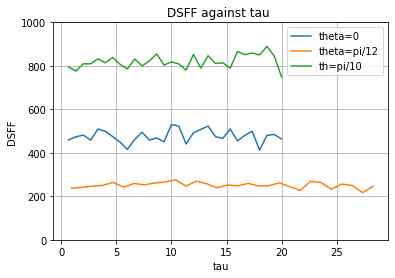

In [90]:
##flattened arrays
ft_D = method.DSFF_.flatten(order='C')
ft_tau = method.tau_matrix.flatten(order='C')

##booleans for specific angles
ag_bool_0 = np.angle(ft_tau) == 0
ag_bool_2 = np.angle(ft_tau) == np.pi/2
ag_bool_4 = np.angle(ft_tau) == np.pi/4
ag_bool_6 = np.angle(ft_tau) == np.pi/6
ag_bool_8 = np.angle(ft_tau) == np.pi/8
ag_bool_10 = np.angle(ft_tau) == np.pi/10
ag_bool_12 = np.angle(ft_tau) == np.pi/12

##DSFF arrays for specific angles
ft_D_0 = ft_D*ag_bool_0
ft_D_2 = ft_D*ag_bool_2
ft_D_4 = ft_D*ag_bool_4
ft_D_6 = ft_D*ag_bool_6
ft_D_8 = ft_D*ag_bool_8
ft_D_10 = ft_D*ag_bool_10
ft_D_12 = ft_D*ag_bool_12

##tau arrays for specific angles
ft_tau_0 = ft_tau*ag_bool_0
ft_tau_2 = ft_tau*ag_bool_2
ft_tau_4 = ft_tau*ag_bool_4
ft_tau_6 = ft_tau*ag_bool_6
ft_tau_8 = ft_tau*ag_bool_8
ft_tau_10 =ft_tau*ag_bool_10
ft_tau_12 =ft_tau*ag_bool_12

##removes zeros 
ft_tau_0 = np.abs(ft_tau_0[ft_tau_0 != 0])
ft_tau_2 = np.abs(ft_tau_2[ft_tau_2 != 0])
ft_tau_4 = np.abs(ft_tau_4[ft_tau_4 != 0])
ft_tau_6 = np.abs(ft_tau_6[ft_tau_6 != 0])
ft_tau_8 = np.abs(ft_tau_8[ft_tau_8 != 0])
ft_tau_10 = np.abs(ft_tau_10[ft_tau_10 != 0])
ft_tau_12 = np.abs(ft_tau_12[ft_tau_12 != 0])

##remove zeros
ft_D_0 = np.abs(ft_D_0[ft_D_0 != 0])
ft_D_2 = np.abs(ft_D_2[ft_D_2 != 0])
ft_D_4 = np.abs(ft_D_4[ft_D_4 != 0])
ft_D_6 = np.abs(ft_D_6[ft_D_6 != 0])
ft_D_8 = np.abs(ft_D_8[ft_D_8 != 0])
ft_D_10 = np.abs(ft_D_10[ft_D_10 != 0])
ft_D_12 = np.abs(ft_D_12[ft_D_12 != 0])

ft_tau_0 = np.abs(ft_tau_0[ft_tau_0 != 0])
ft_tau_2 = np.abs(ft_tau_2[ft_tau_2 != 0])
ft_tau_4 = np.abs(ft_tau_4[ft_tau_4 != 0])
ft_tau_6 = np.abs(ft_tau_6[ft_tau_6 != 0])
ft_tau_8 = np.abs(ft_tau_8[ft_tau_8 != 0])
ft_tau_10 = np.abs(ft_tau_10[ft_tau_10 != 0])
ft_tau_12 = np.abs(ft_tau_12[ft_tau_12 != 0])

plt.plot(ft_tau_0,np.delete(ft_D_0,0))
# plt.plot(ft_tau_12,ft_D_12)
# plt.plot(ft_tau_10,ft_D_10)
# plt.plot(ft_tau_8,ft_D_8)
# plt.plot(ft_tau_6,ft_D_6)
plt.plot(ft_tau_4,ft_D_4)
plt.plot(ft_tau_2,ft_D_2)


plt.legend(['theta=0','theta=pi/12','th=pi/10','th=pi/8','th=pi/6','th=pi/4','th=pi/2','th=pi'])
plt.grid()
plt.xlabel('tau')
plt.ylabel('DSFF')
plt.title('DSFF against tau ')
plt.ylim(0,1000)
plt.show()


In [92]:
Qobj(np.angle(method.tau_matrix))/np.pi

Quantum object: dims = [[61], [61]], shape = (61, 61), type = oper, isherm = False
Qobj data =
[[-0.75       -0.75539457 -0.76097186 ...  0.76097186  0.75539457
   0.75      ]
 [-0.74460543 -0.75       -0.75558381 ...  0.75558381  0.75
   0.74460543]
 [-0.73902814 -0.74441619 -0.75       ...  0.75        0.74441619
   0.73902814]
 ...
 [-0.26097186 -0.25558381 -0.25       ...  0.25        0.25558381
   0.26097186]
 [-0.25539457 -0.25       -0.24441619 ...  0.24441619  0.25
   0.25539457]
 [-0.25       -0.24460543 -0.23902814 ...  0.23902814  0.24460543
   0.25      ]]

In [25]:
res = 181
av = 1000
secs = ((1.9*60)/(81*81*10))*res*res*av
mins = secs/60
hours = mins/60
print(secs)
print(mins)
print(hours)

56923.54823959762
948.7258039932937
15.81209673322156


In [ ]:
every entry is a random complex number for a matrix,
potentially average over to
check if it gives figure 1c, 

look at paper for specific (gaussian distribution)
(non hermitian)

Use random Louvillian (5th model)

this has an added simplification of no symmetries so there 
isnt any projection needed.

-Could do floquet version of this, so this is very 
important to check

Do check with the projection function.


Spectral statistics of non-Hermitian matrices and dissipative quantum chaos



set symmetry of the hamiltonian to be block diagonal but 
dont set the jump operators to have this 
so it doesnt intefere 

In unitary case:
    Form factor K(t)
    Random unitary matrix, U[N x N] 
    and diagonalise it,
    everything is a phase.
    The K(t) has a universal form (figure 2 in the spectral form factor)
    and it flattens out at t=N
    when you put in symmetries, the thouless time,
    which tells you something about diffusion.
    The conserved quantity and conservation law (current conservation)
    where j (current) is a gradient, which leads to 
    a diffusion equation. So diffusion is a 
    statement of conservation. hydrodynamics?
    what kinds of hamiltionians give rise to hydrodynamics.
    When a particle diffuses it takes a certain time to go 
    a certain distance (d^2 prop to t)
    in QM, t relates to energy scale. 
    If theres a conservation law theres a dip (see picture)
    at the thouless time, and then it goes to linear relation.
    This is all in unitary case.
IN dissipative case:
    Should be the same? 
    
    Look at the paper he put on chat, we want to try the same method with 
    random Louvillian (with Hamilitian symmetries)
    

First:
    Calculate K(t) for unitary case, then for dissipative case.
    Try to recreate spectral form factor of dissipative system,
    then put some symmetries into H,
    and then maybe put symmetries into jump operators.

method.inputs